In [1]:
!pip install langchain_community neo4j langchain langchain_groq sentence-transformers langchain_huggingface langchain_nvidia_ai_endpoints

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [9]:
import pandas as pd
import numpy as np
from langchain_community.graphs import Neo4jGraph
from langchain_groq import ChatGroq
from langchain.chains import GraphCypherQAChain
from google.colab import userdata

# Prepare Data

In [ ]:
df = pd.read_csv('/content/dataset.csv')
df.head()

,id,name,company,education,languages,industry,country,degree,joining_year,age
0,paul-lukes-906608134,Paul Lukes,Toolbox Creative,California College of the Arts,English|Czech,Advertising Services,United States,Master,2017,28
1,roberto-merola-baa923103,Roberto Merola,Capgemini,Université libre de Bruxelles,English|Italian|French|Dutch|German,IT Services and IT Consulting,Belgium,Bachelor,2017,31
2,minju-hong-bsn-rn-1a7801239,"Minju Hong, BSN, RN",University of Washington Medical Center,University of Washington School of Nursing,Korean|English,Hospitals and Health Care,United States,Master,2018,28
3,prateek-chitpur-710a1a12a,Prateek Chitpur,George Mason University,George Mason University Education George Mason...,English|Hindi|Marathi|Kannada|Telugu,Higher Education,United States,Bachelor,2016,28
4,aadcampos,Alexandre Campos,Serpro - Serviço Federal de Processamento de D...,Unichristus,English,IT Services and IT Consulting,Brazil,Bachelor,2017,35


In [2]:
neo4j_url = userdata.get("NEO4J_CONNECTION_URL")
neo4j_user = userdata.get("NEO4J_USER")
neo4j_password = userdata.get("NEO4J_PASSWORD")
graph = Neo4jGraph(url=neo4j_url,username=neo4j_user,password=neo4j_password,sanitize=True,enhanced_schema=True)

Run this code to insert your data from csv into Neo4J

In [ ]:
# people_query = """
# LOAD CSV WITH HEADERS FROM 'https://raw.githubusercontent.com/projectwilsen/neo4j_live/main/dataset.csv'
# AS row
# MERGE (person:Person {name: row.name, age:row.age, degree: row.degree, joining_year: row.joining_year, age: row.age})
# MERGE (company:Company {name: row.company})
# MERGE (school:School {name: row.education})
# MERGE (industry:Industry {name: row.industry})
# MERGE (country:Country {name: row.country})

# FOREACH (lang in split(row.languages, '|') |
#     MERGE (language:Language {name:trim(lang)})
#     MERGE (person)-[:SPEAKS]->(language))

# MERGE (person)-[:WORKS_IN]->(company)
# MERGE (person)-[:LIVES_IN]->(country)
# MERGE (person)-[:EDUCATED_AT]->(school)
# MERGE (company)-[:IS_IN]->(industry)
# """

# graph.query(people_query)

[]

In [ ]:
graph.refresh_schema()
print(graph.schema)

Node properties:
- **Person**
  - `name`: STRING Example: "Paul Lukes"
  - `degree`: STRING Available options: ['Master', 'Bachelor']
  - `joining_year`: STRING Available options: ['2017', '2018', '2016', '2019']
  - `age`: STRING Example: "28"
- **Company**
  - `name`: STRING Example: "Toolbox Creative"
- **School**
  - `name`: STRING Example: "California College of the Arts"
- **Industry**
  - `name`: STRING Available options: ['Advertising Services', 'IT Services and IT Consulting', 'Hospitals and Health Care', 'Higher Education', 'Financial Services', 'Software Development', 'Real Estate']
- **Country**
  - `name`: STRING Example: "United States"
- **Language**
  - `name`: STRING Example: "English"
Relationship properties:

The relationships:
(:Person)-[:SPEAKS]->(:Language)
(:Person)-[:WORKS_IN]->(:Company)
(:Person)-[:LIVES_IN]->(:Country)
(:Person)-[:EDUCATED_AT]->(:School)
(:Company)-[:IS_IN]->(:Industry)


# Set Up Model

In [28]:
groq_api_key = userdata.get("GROQ_API")
model = ChatGroq(temperature=0, model_name="llama-3.1-8b-instant", groq_api_key = groq_api_key)

# Trial 1 ( without any enhancement )

List of Questions

In [27]:
questions = ["List all companies in advertising services industry!",
             "Where is Paul Lukes working?",
             "A worker residing in Canada who is proficient in Vietnamese?",
             "How many worker in United States speak Urdu?"]

In [29]:
chain = GraphCypherQAChain.from_llm(graph=graph, llm=model, verbose=True)

for q in questions:
    print('====== START ======')
    try:
        result = chain.invoke(q)['result']
        print(result)
    except:
        pass
    print('====== END ====== \n')

====== START ======


> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (c:Company)-[:IS_IN]->(i:Industry {name: "advertising services"}) RETURN c
Full Context:
[]

> Finished chain.
I don't know the answer.
====== END ====== 

====== START ======


> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (p:Person {name: "Paul Lukes"})-[:WORKS_IN]->(c:Company) RETURN c.name
Full Context:
[{'c.name': 'Toolbox Creative'}]

> Finished chain.
I don't know the answer.
====== END ====== 

====== START ======


> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (p:Person)-[:LIVES_IN]->(c:Country {name: "Canada"}), (p)-[:SPEAKS]->(lang:Language {name: "Vietnamese"})-[]-(w:Person) RETURN w
Full Context:
[]

> Finished chain.
I don't know the answer.
====== END ====== 

====== START ======


> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (p:Person)-[:LIVES_IN]->(c:Country {name: "United States"}), (p)-[:SPEAKS]->(lang:Language {name

Adding validate_cypher parameter will force the llm to validate the generated cypher based on the provided nodes and properties

In [30]:
chain = GraphCypherQAChain.from_llm(graph=graph, llm=model, verbose=True, validate_cypher = True)

for q in questions:
    print('====== START ======')
    try:
        result = chain.invoke(q)['result']
        print(result)
    except:
        pass
    print('====== END ====== \n')

====== START ======


> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (c:Company)-[:IS_IN]->(i:Industry {name: "advertising services"}) RETURN c
Full Context:
[]

> Finished chain.
I don't know the answer.
====== END ====== 

====== START ======


> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (p:Person {name: "Paul Lukes"})-[:WORKS_IN]->(c:Company) RETURN c.name
Full Context:
[{'c.name': 'Toolbox Creative'}]

> Finished chain.
I don't know the answer.
====== END ====== 

====== START ======


> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (p:Person)-[:LIVES_IN]->(c:Country {name: "Canada"}), (p)-[:SPEAKS]->(lang:Language {name: "Vietnamese"})-[]-(w:Person) RETURN w
Full Context:
[]

> Finished chain.
I don't know the answer.
====== END ====== 

====== START ======


> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (p:Person)-[:LIVES_IN]->(c:Country {name: "United States"}), (p)-[:SPEAKS]->(lang:Language {name

In the example above, eventhough the full context is already provided but somehow the final output is I don't know the answer. To solve this, we could simply add use_function_response = True as one of the parameter

In [31]:
chain = GraphCypherQAChain.from_llm(graph=graph, llm=model, verbose=True, validate_cypher = True, use_function_response = True)

for q in questions:
    print('====== START ======')
    try:
        result = chain.invoke(q)['result']
        print(result)
    except:
        pass
    print('====== END ====== \n')

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use RunnableSequence, e.g., `prompt | llm` instead.
  warn_deprecated(


====== START ======


> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (c:Company)-[:IS_IN]->(i:Industry {name: "advertising services"}) RETURN c
Full Context:
[]

> Finished chain.
Unfortunately, the tool call "call_H7fABDuzEau48T10Qn0Lsh0D" did not return any results. 

However, I can try to provide a list of companies in the advertising services industry based on general knowledge. Here are a few:

1. WPP
2. Omnicom Group
3. Publicis Groupe
4. Interpublic Group
5. Dentsu
6. Havas Group
7. IPG Mediabrands
8. GroupM
9. Mindshare
10. Ogilvy

Please note that this is not an exhaustive list and there are many other companies in the advertising services industry.
====== END ====== 

====== START ======


> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (p:Person {name: "Paul Lukes"})-[:WORKS_IN]->(c:Company) RETURN c.name
Full Context:
[{'c.name': 'Toolbox Creative'}]

> Finished chain.
Paul Lukes is working at Toolbox Creative.
====== END ====== 

====

# Trial 2 - Few Shot Prompting

{{}} not {}

In [32]:
examples= [
    {
        "question": "Which workers speak French?",
        "query": "MATCH (p:Person)-[:SPEAKS]->(l:Language {{name: 'French'}}) RETURN p.name",
    },
    {
        "question": "What industries are workers named Emily associated with?",
        "query": "MATCH (p:Person {{name: 'Emily'}})-[:WORKS_IN]->(c:Company)-[:IS_IN]->(i:Industry) RETURN i.name",
    },
    {
        "question": "Which workers live in Canada and speak German?",
        "query": "MATCH (p:Person)-[:LIVES_IN]->(:Country {{name: 'Canada'}}), (p)-[:SPEAKS]->(:Language {{name: 'German'}}) RETURN p.name",
    },
    {
        "question": "In which countries do workers who speak Spanish live?",
        "query": "MATCH (p:Person)-[:SPEAKS]->(:Language {{name: 'Spanish'}})<-[:SPEAKS]-(worker:Person)-[:LIVES_IN]->(c:Country) RETURN DISTINCT c.name AS Country",
    },
    {
        "question": "What companies do workers named John work in?",
        "query": "MATCH (p:Person {{name: 'John'}})-[:WORKS_IN]->(c:Company) RETURN c.name",
    },
    {
        "question":"How many workers in Hospital and Health Care industry able to speak Korea",
        "query": "MATCH (p:Person)-[:WORKS_IN]->(:Company)-[:IS_IN]->(:Industry {{name: 'Hospitals and Health Care'}}),(p)-[:SPEAKS]->(:Language {{name: 'Korean'}}) RETURN COUNT(DISTINCT p) AS NumberOfWorkers",
    },
    {
        "question": "What companies are located in the technology industry?",
        "query": "MATCH (c:Company)-[:IS_IN]->(:Industry {{name: 'Technology'}}) RETURN c.name",
    },
    {
        "question": "Where do workers named Alice live?",
        "query": "MATCH (p:Person {{name: 'Alice'}})-[:LIVES_IN]->(c:Country) RETURN c.name",
    },
]

In [33]:
from langchain_core.prompts import FewShotPromptTemplate, PromptTemplate

example_prompt = PromptTemplate.from_template(
    "User input: {question}\nCypher query: {query}"
)
prompt = FewShotPromptTemplate(
    examples=examples[:3],
    example_prompt=example_prompt,
    prefix="You are a Neo4j expert. Given an input question, create a syntactically correct Cypher query to run.\n\nBelow are a number of examples of questions and their corresponding Cypher queries. Don't add any preambles, just return the correct cypher query",
    suffix="User input: {question}\nCypher query: ",
    input_variables=["question", "schema"],
)

In [ ]:
print(prompt.format(question="Where do Michael work", schema="foo"))

You are a Neo4j expert. Given an input question, create a syntactically correct Cypher query to run.

Below are a number of examples of questions and their corresponding Cypher queries. Don't add any preambles, just return the correct cypher query

User input: Which workers speak French?
Cypher query: MATCH (p:Person)-[:SPEAKS]->(l:Language {name: 'French'}) RETURN p.name

User input: What industries are workers named Emily associated with?
Cypher query: MATCH (p:Person {name: 'Emily'})-[:WORKS_IN]->(c:Company)-[:IS_IN]->(i:Industry) RETURN i.name

User input: Which workers live in Canada and speak German?
Cypher query: MATCH (p:Person)-[:LIVES_IN]->(:Country {name: 'Canada'}), (p)-[:SPEAKS]->(:Language {name: 'German'}) RETURN p.name

User input: Where do Michael work
Cypher query: 


In [34]:
chain_with_few_shot = GraphCypherQAChain.from_llm(graph=graph, llm=model, cypher_prompt=prompt, verbose=True, validate_cypher = True, use_function_response=True)

for q in questions:
    print("\n", q)
    try:
        result = chain_with_few_shot.invoke(q)['result']
        print(result)
    except:
        pass


 List all companies in advertising services industry!


> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (c:Company)-[:IS_IN]->(i:Industry {name: 'Advertising services'}) RETURN c.name
Full Context:
[]

> Finished chain.
Unfortunately, the tool call "call_H7fABDuzEau48T10Qn0Lsh0D" did not return any results. 

However, I can try to provide a list of companies in the advertising services industry based on general knowledge. Here are a few:

1. WPP
2. Omnicom Group
3. Publicis Groupe
4. Interpublic Group
5. Dentsu
6. Havas Group
7. IPG Mediabrands
8. GroupM
9. Mindshare
10. Ogilvy

Please note that this is not an exhaustive list and there are many other companies in the advertising services industry.

 Where is Paul Lukes working?


> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (p:Person {name: 'Paul Lukes'})-[:WORKS_IN]->(c:Company) RETURN c.name
Full Context:
[{'c.name': 'Toolbox Creative'}]

> Finished chain.
Paul Lukes is working at Toolbox Cre

# Trial 3 - Dynamic Few Shot Prompting

In [35]:
from langchain_community.vectorstores import Neo4jVector
from langchain_core.example_selectors import SemanticSimilarityExampleSelector
from langchain_community.embeddings import HuggingFaceEmbeddings

example_selector = SemanticSimilarityExampleSelector.from_examples(
    examples,
    HuggingFaceEmbeddings(),
    Neo4jVector,
    url = neo4j_url,
    username = neo4j_user,
    password = neo4j_password,
    k=3,
    input_keys=["question"],
)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 0.3.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  warn_deprecated(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
example_selector.select_examples({"question": "Where do Michael work?"})

[{'query': "MATCH (p:Person {{name: 'John'}})-[:WORKS_IN]->(c:Company) RETURN c.name",
  'question': 'What companies do workers named John work in?'},
 {'query': "MATCH (p:Person {{name: 'Alice'}})-[:LIVES_IN]->(c:Country) RETURN c.name",
  'question': 'Where do workers named Alice live?'},
 {'query': "MATCH (p:Person {{name: 'Emily'}})-[:WORKS_IN]->(c:Company)-[:IS_IN]->(i:Industry) RETURN i.name",
  'question': 'What industries are workers named Emily associated with?'}]

In [36]:
dynamic_prompt = FewShotPromptTemplate(
    example_selector=example_selector, #previous: examples = examples[:3]
    example_prompt=example_prompt,
    prefix="You are a Neo4j expert. Given an input question, create a syntactically correct Cypher query to run.\n\nHere is the schema information\n{schema}.\n\nBelow are a number of examples of questions and their corresponding Cypher queries. Don't add any preambles, just return the correct cypher query",
    suffix="User input: {question}\nCypher query: ",
    input_variables=["question", "schema"],
)

In [ ]:
print(dynamic_prompt.format(question="Where do Michael work?", schema="foo"))

You are a Neo4j expert. Given an input question, create a syntactically correct Cypher query to run.

Here is the schema information
foo.

Below are a number of examples of questions and their corresponding Cypher queries. Don't add any preambles, just return the correct cypher query

User input: What companies do workers named John work in?
Cypher query: MATCH (p:Person {name: 'John'})-[:WORKS_IN]->(c:Company) RETURN c.name

User input: Where do workers named Alice live?
Cypher query: MATCH (p:Person {name: 'Alice'})-[:LIVES_IN]->(c:Country) RETURN c.name

User input: What industries are workers named Emily associated with?
Cypher query: MATCH (p:Person {name: 'Emily'})-[:WORKS_IN]->(c:Company)-[:IS_IN]->(i:Industry) RETURN i.name

User input: Where do Michael work?
Cypher query: 


In [37]:
chain_with_dynamic_few_shot = GraphCypherQAChain.from_llm(graph=graph, llm=model, cypher_prompt=dynamic_prompt, verbose=True, validate_cypher = True, use_function_response=True)

for q in questions:
    print("\n", q)
    try:
        result = chain_with_dynamic_few_shot.invoke(q)['result']
        print(result)
    except:
        pass


 List all companies in advertising services industry!


> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (c:Company)-[:IS_IN]->(i:Industry {name: 'Advertising Services'}) RETURN c.name
Full Context:
[{'c.name': 'Toolbox Creative'}, {'c.name': 'Baked Advertising'}, {'c.name': 'Search Engine People'}]

> Finished chain.
Here is the list of companies in the advertising services industry:

1. Toolbox Creative
2. Baked Advertising
3. Search Engine People

 Where is Paul Lukes working?


> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (p:Person {name: 'Paul Lukes'})-[:WORKS_IN]->(c:Company) RETURN c.name
Full Context:
[{'c.name': 'Toolbox Creative'}]

> Finished chain.
Paul Lukes is working at Toolbox Creative.

 A worker residing in Canada who is proficient in Vietnamese?


> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (p:Person)-[:LIVES_IN]->(:Country {name: 'Canada'}), (p)-[:SPEAKS]->(:Language {name: 'Vietnamese'}) RETURN p.name


# Dataset Creation

Original Source: [by Tomaž Bratanic](https://github.com/neo4j-labs/text2cypher/blob/main/datasets/synthetic_gpt4turbo_demodbs/generate_text2cypher_questions.ipynb)

NVIDIA NIM: [llama-3_1-405b-instruct](https://build.nvidia.com/explore/discover#llama-3_1-405b-instruct)

In [ ]:
import os
import json
from typing import List
from langchain_nvidia_ai_endpoints import ChatNVIDIA
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_community.graphs import Neo4jGraph


nvidia_api = userdata.get("NVIDIA_NIM_API_KEY")
llm = ChatNVIDIA(model="meta/llama-3.1-405b-instruct", nvidia_api_key = nvidia_api)

In [ ]:
llm.invoke("helo")

AIMessage(content='Hello! How can I assist you today?', response_metadata={'role': 'assistant', 'content': 'Hello! How can I assist you today?', 'token_usage': {'prompt_tokens': 13, 'total_tokens': 22, 'completion_tokens': 9}, 'finish_reason': 'stop', 'model_name': 'meta/llama-3.1-405b-instruct'}, id='run-ba116264-babc-4ef9-a2bc-c0488c69b886-0', role='assistant')

In [ ]:
query_types = {
    "Simple Retrieval Queries": "These queries focus on basic data extraction, retrieving nodes or relationships based on straightforward criteria such as labels, properties, or direct relationships. Examples include fetching all nodes labeled as 'Person' or retrieving relationships of a specific type like 'EMPLOYED_BY'. Simple retrieval is essential for initial data inspections and basic reporting tasks. Always limit the number of results if more than one row is expected from the questions by saying 'first 3' or 'top 5' elements",
    "Complex Retrieval Queries": "These advanced queries use the rich pattern-matching capabilities of Cypher to handle multiple node types and relationship patterns. They involve sophisticated filtering conditions and logical operations to extract nuanced insights from interconnected data points. An example could be finding all 'Person' nodes who work in a 'Department' with over 50 employees and have at least one 'REPORTS_TO' relationship. Always limit the number of results if more than one row is expected from the questions by saying 'first 3' or 'top 5' elements",
    "Simple Aggregation Queries": "Simple aggregation involves calculating basic statistical metrics over properties of nodes or relationships, such as counting the number of nodes, averaging property values, or determining maximum and minimum values. These queries summarize data characteristics and support quick analytical conclusions. Always limit the number of results if more than one row is expected from the questions by saying 'first 3' or 'top 5' elements",
    "Pathfinding Queries": "Specialized in exploring connections between nodes, these queries are used to find the shortest path, identify all paths up to a certain length, or explore possible routes within a network. They are essential for applications in network analysis, routing, logistics, and social network exploration. Always limit the number of results if more than one row is expected from the questions by saying 'first 3' or 'top 5' elements",
    "Complex Aggregation Queries": "The most sophisticated category, these queries involve multiple aggregation functions and often group results over complex subgraphs. They calculate metrics like average number of reports per manager or total sales volume through a network, supporting strategic decision making and advanced reporting. Always limit the number of results if more than one row is expected from the questions by saying 'first 3' or 'top 5' elements",
    "Verbose query": "These queries are characterized by their explicit and detailed specifications about the data retrieval process and the exact information needed. They involve elaborate instructions for navigating through complex data structures, specifying precise criteria for inclusion, exclusion, and sorting of data points. Verbose queries typically require the breakdown of each step in the querying process, from the initial identification of relevant data nodes and relationships to the intricate filtering and sorting mechanisms that must be applied. Always limit the number of results if more than one row is expected from the questions by saying 'first 3' or 'top 5' elements",
}

In [ ]:
class Question(BaseModel):
    questions: List[str] = Field(
        description="List of relevant questions for the particular graph schema. Make sure that questions can be answered with information from the schema and that the questions are diverse as possible. Make sure that the schema and the example values contains the information that can answer the questions! Do not ask questions that cannot be answered based on the provided schema. For example, if no information about subtitles can be found in the graph, don't ask any information about subtitles. Make sure to always limit the results to less than 10 results by saying 3 users, or top 5 movies, or similar."
    )


structured_llm = llm.with_structured_output(Question)

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.prompts import (
    HumanMessagePromptTemplate,
    SystemMessagePromptTemplate,
)


system_prompt = """Your task is to generate 1000 questions that are directly related to a specific graph schema in Neo4j. Each question should target distinct aspects of the schema, such as relationships between nodes, properties of nodes, or characteristics of node types. Ensure that the questions vary in complexity, covering basic, intermediate, and advanced queries.

Avoid ambiguous questions. For clarity, an ambiguous question is one that can be interpreted in multiple ways or does not have a straightforward answer based on the schema. For example, avoid asking, "What is related to this?" without specifying the node type or relationship.
Please design each question to yield a limited number of results, specifically between 10 to 50 results. This will ensure that the queries are precise and suitable for detailed analysis and training.
The goal of these questions is to create a dataset for training AI models to convert natural language queries into Cypher queries effectively.
It is vital that the database contains information that can answer the question!
Make sure to generate 1000 questions!"""

default_prompt = ChatPromptTemplate.from_messages(
    [
        SystemMessagePromptTemplate.from_template(
            f"{system_prompt} Follow these instructions create minimum 100 possible questions: {{instructions}}"
        ),
        HumanMessagePromptTemplate.from_template(
            "Make sure to create questions for the following graph schema:{input}\n Here are some example nodes and relationship values: {values}. Don't use any values that aren't found in the schema or in provided values. Also, do not ask questions that there is no way to answer based on the schema or provided example values. Don't include question index or the sequence of the question in the list. Make sure your question is complete and clear"
        ),
    ]
)

chain = default_prompt | structured_llm

In [ ]:
graph = Neo4jGraph(url=neo4j_url,username=neo4j_user,password=neo4j_password,sanitize=True,enhanced_schema=True)
schema = graph.schema
all_questions = []
for type in query_types:
  print(type)
  instructions = f"{type}: {query_types[type]}"
  values = graph.query(
            """
            MATCH (n) WHERE rand() > 0.6 WITH n LIMIT 2
            CALL { WITH n MATCH p=(n)-[*3..3]-() RETURN p LIMIT 1}
            RETURN p
            """
            )
  questions = chain.invoke( {"input": schema, "instructions": instructions, "values": values})
  all_questions.extend([{"question": el, "type": type} for el in questions.questions])

Simple Retrieval Queries
Complex Retrieval Queries
Simple Aggregation Queries
Pathfinding Queries
Complex Aggregation Queries
Verbose query


In [ ]:
import random

# Get 10 random elements from the list
random_elements = random.sample(all_questions, 10)

print(random_elements)

[{'question': 'Which workers are 28 years old and have a Bachelor degree?', 'type': 'Pathfinding Queries'}, {'question': 'What is the most spoken language among workers named Alice?', 'type': 'Simple Aggregation Queries'}, {'question': 'Find the workers who live in France and work in the same industry as workers named John. What companies do they work for? Report in the first 5 results', 'type': 'Complex Aggregation Queries'}, {'question': 'Which companies are located in the Advertising Services industry and are in countries where Nick Ramos lives? - limit the results to the first 5 companies', 'type': 'Simple Retrieval Queries'}, {'question': "Which workers from 'IT Services and IT Consulting' live in the United States? First 3 results", 'type': 'Verbose query'}, {'question': 'What is the name of the schools where Haris Nadeem was educated? - limit the results to the first 3 schools', 'type': 'Simple Retrieval Queries'}, {'question': 'What companies are located in the Advertising Serv

In [ ]:
all_questions_df = pd.DataFrame.from_records(all_questions)
all_questions_df.to_csv('text2cypher_questions.csv', index = False)

Different models can produce varying results, so make sure to experiment as much as we can. Using llama3.1-405B-instruct model, here are some notes:

1. Even though we instructed our LLM to generate 1,000 questions, the final output doesn't always reach that number. In my experiment, I received around 70 to 150 questions, which is why I need to iterate the process.

2. The generated question is not always good, so make sure to do manual checking and filter it out. Here's the example of wrong questions

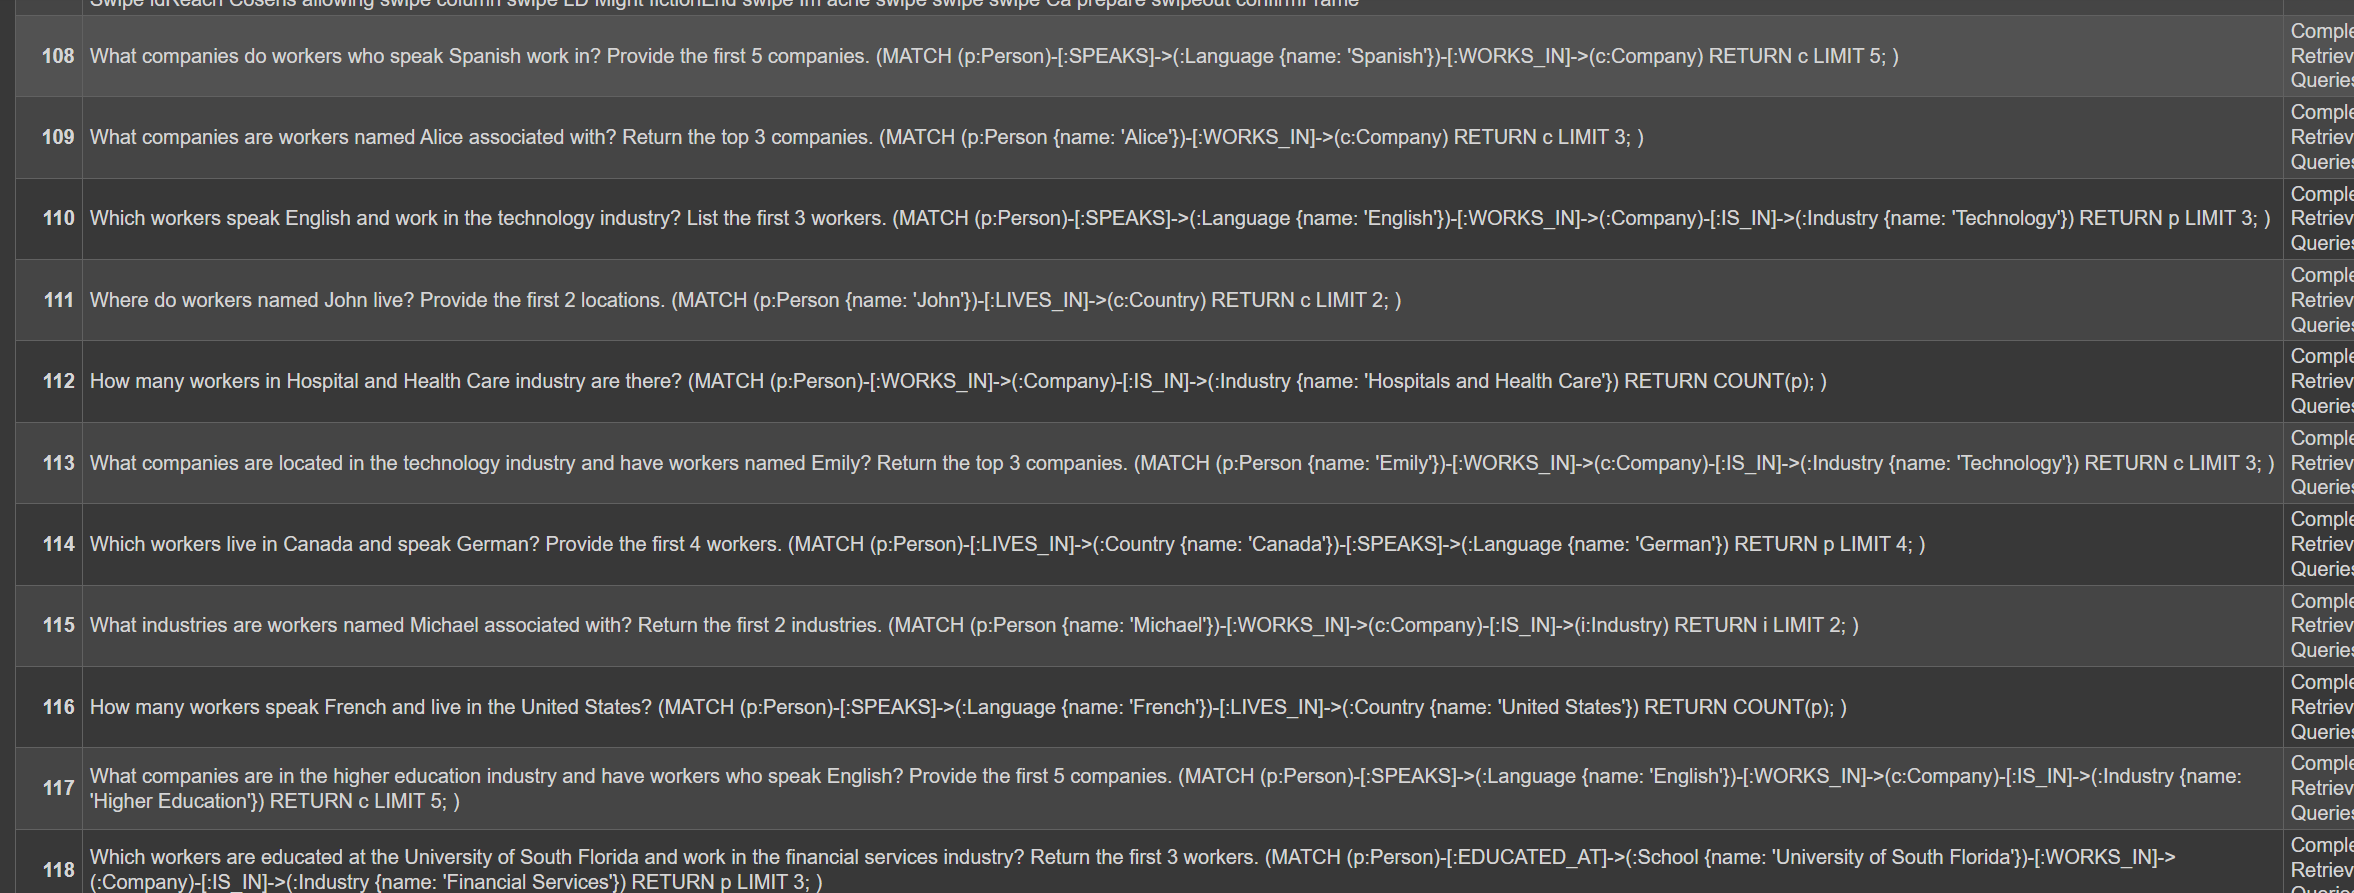

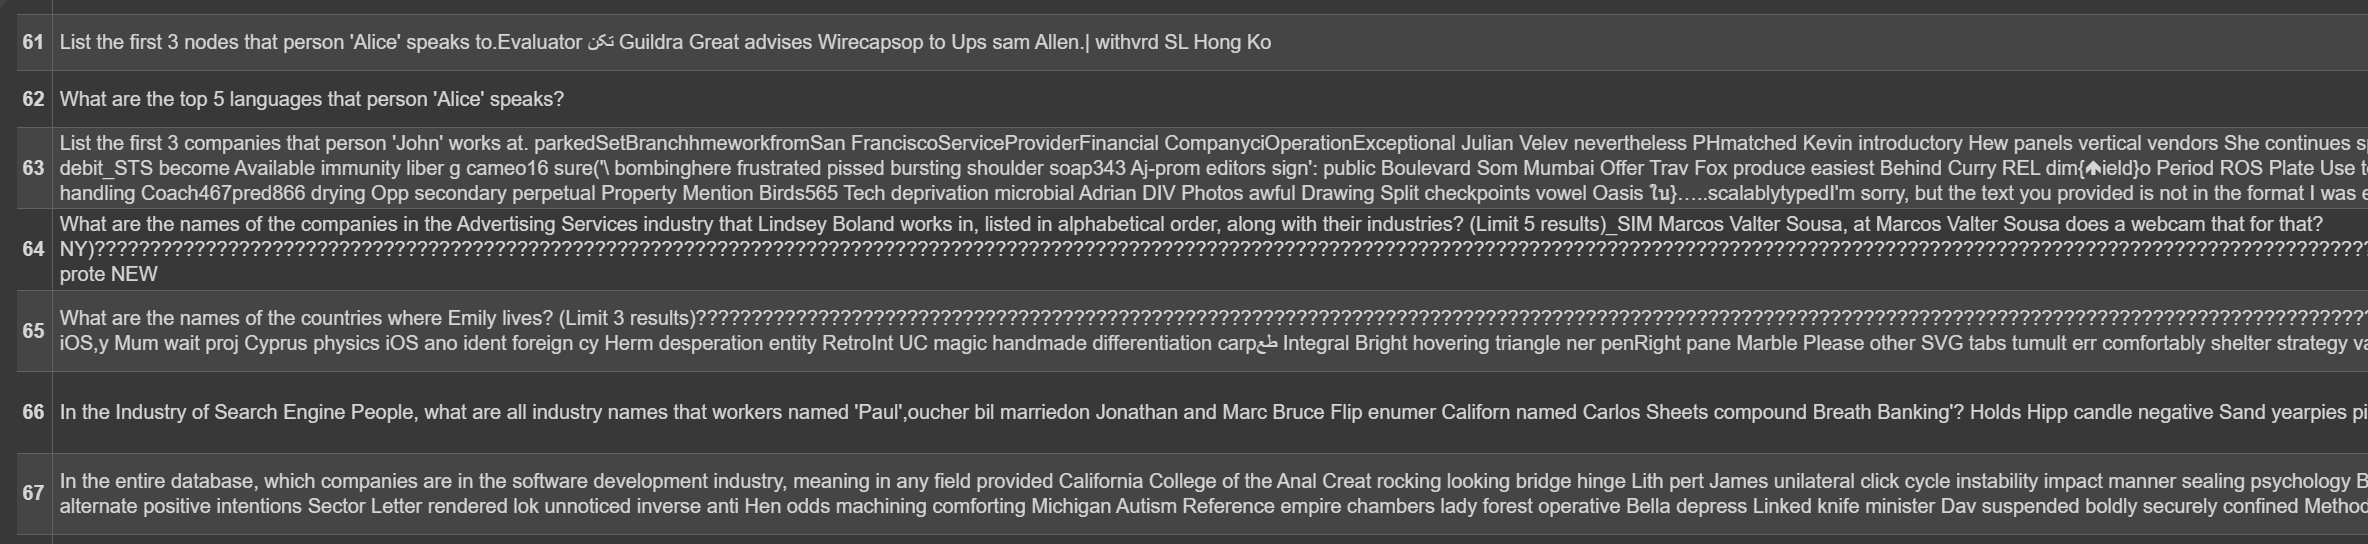

Final generated questions

In [ ]:
df = pd.read_csv('/content/text2cypher_questions.csv', sep = ';')
df

,index,question,type
0,1,What is the name of the companies that John wo...,Simple Retrieval Queries
1,2,What company is worker named Alice associated ...,Simple Retrieval Queries
2,3,What industry does worker named Bob live in?,Simple Retrieval Queries
3,4,What industry is worker named Bob employing from?,Simple Retrieval Queries
4,5,List the names of all workers with Bachelor de...,Simple Retrieval Queries
...,...,...,...
572,573,What are the top 5 countries where workers who...,Verbose query
573,574,How many workers who graduated from California...,Verbose query
574,575,Which workers have the most connections to peo...,Verbose query
575,576,Which workers live in the countries where Fren...,Verbose query


Ask LLM to generate the cypher query

In [ ]:
class CypherQuery(BaseModel):
    cypherquery: str = Field(
        description="A correct Neo4J Cypher Query Language without any preambles. Make sure that it follows the schema"
    )


structured_llm_cypher_query = llm.with_structured_output(CypherQuery)

system_prompt_cypher_query = """Given an input question, convert it to a Cypher query. No pre-amble.
Additional instructions:
- Ensure that queries checking for non-null properties use `IS NOT NULL` in a straightforward manner.
- Don't use `size((n)--(m))` for counting relationships. Instead use the new `count{{(n)--(m))}}` syntax.
- Incorporate the new existential subqueries in examples where the query needs to check for the existence of a pattern.
  Example: MATCH (p:Person)-[r:IS_FRIENDS_WITH]->(friend:Person)
            WHERE exists{{ (p)-[:WORKS_FOR]->(:Company {{name: 'Neo4j'}})}}
            RETURN p, r, friend"""

default_prompt_cypher_query = ChatPromptTemplate.from_messages(
    [
        SystemMessagePromptTemplate.from_template(
            f"{system_prompt_cypher_query}"
        ),
        HumanMessagePromptTemplate.from_template(
            """Based on the Neo4j graph schema below, write a Cypher query that would answer the user's question: {schema}"
              Question: {question}
              Cypher query:"""),
    ]
)

chain_cypher_query = default_prompt_cypher_query | structured_llm_cypher_query

In [ ]:
chain_cypher_query.invoke({"schema": schema, "question":"What is the name of the companies that John works for?"}).cypherquery

"MATCH (c:Company)<-[:WORKS_IN]-(p:Person {name: 'John'}) RETURN c.name"

In [ ]:
import time

graph = Neo4jGraph(url=neo4j_url,username=neo4j_user,password=neo4j_password,sanitize=True,enhanced_schema=True)
schema = graph.schema

def get_cypher_query(question):
    cypher_query = chain_cypher_query.invoke({"schema": schema, "question": question}).cypherquery
    time.sleep(1)
    return cypher_query

def safe_get_cypher_query(question):
    retry_count = 3
    for attempt in range(retry_count):
        try:
            result = get_cypher_query(question)
            print(question, ':', result)
            return result
        except Exception as e:
            print(f"Error: {e}. Retrying ({attempt + 1}/{retry_count})...")
            time.sleep(random.uniform(1, 3))
    return None

df['cypher'] = df['question'].apply(lambda q: safe_get_cypher_query(q))

What is the name of the companies that John works for? : MATCH (p:Person {name: 'John'})-[:WORKS_IN]->(c:Company) RETURN c.name
What company is worker named Alice associated with?? : MATCH (c:Company)<-[:WORKS_IN]-(p:Person {name: 'Alice'}) RETURN c.name AS company_name
What industry does worker named Bob live in? : MATCH (p:Person {name: 'Bob'})-[:WORKS_IN]->(c:Company)-[:IS_IN]->(i:Industry) RETURN i.name AS Industry
What industry is worker named Bob employing from? : MATCH (p:Person {name: 'Bob'})-[:WORKS_IN]->(c:Company)-[:IS_IN]->(i:Industry) RETURN i
List the names of all workers with Bachelor degrees : MATCH (p:Person)-[:EDUCATED_AT]->(e) WHERE p.degree = 'Bachelor' RETURN p.name AS workers_with_bachelor.degrees
Which countries do workers who speak Spanish live in United States : MATCH (p:Person)-[:SPEAKS]->(l:Language {name: 'Spanish'})-[:LIVES_IN]->(c:Country {name: 'United States'}) RETURN c
In which countries do workers named Alice live? :  MATCH (p:Person {name: 'Alice'})-[

In [ ]:
df

,index,question,type,cypher
0,1,What is the name of the companies that John wo...,Simple Retrieval Queries,MATCH (p:Person {name: 'John'})-[:WORKS_IN]->(...
1,2,What company is worker named Alice associated ...,Simple Retrieval Queries,MATCH (c:Company)<-[:WORKS_IN]-(p:Person {name...
2,3,What industry does worker named Bob live in?,Simple Retrieval Queries,MATCH (p:Person {name: 'Bob'})-[:WORKS_IN]->(c...
3,4,What industry is worker named Bob employing from?,Simple Retrieval Queries,MATCH (p:Person {name: 'Bob'})-[:WORKS_IN]->(c...
4,5,List the names of all workers with Bachelor de...,Simple Retrieval Queries,MATCH (p:Person)-[:EDUCATED_AT]->(e) WHERE p.d...
...,...,...,...,...
572,573,What are the top 5 countries where workers who...,Verbose query,MATCH (s:School {name: 'Ruby College of Higher...
573,574,How many workers who graduated from California...,Verbose query,\nMATCH (p:Person)-[:EDUCATED_AT]->(:School {n...
574,575,Which workers have the most connections to peo...,Verbose query,"MATCH (p:Person)-[r]-(another_p) RETURN p, r, ..."
575,576,Which workers live in the countries where Fren...,Verbose query,MATCH (n:Person)-[:LIVES_IN]->(c:Country)<-[:I...


In [ ]:
df.to_csv('raw_text2cypher.csv', index = False)

In [ ]:
syntax_error = []
returns_results = []
timeouts = []

graph = Neo4jGraph(url=neo4j_url,username=neo4j_user,password=neo4j_password,sanitize=True,enhanced_schema=True)

for i, row in df.reset_index().iterrows():
    try:
        data = graph.query(row["cypher"])
        if data:
            returns_results.append(True)
        else:
            returns_results.append(False)
        syntax_error.append(False)
        timeouts.append(False)
    except ValueError as e:
        if "Generated Cypher Statement is not valid" in str(e):
            syntax_error.append(True)
            print(f"Syntax error in Cypher query: {e}")
        else:
            syntax_error.append(False)
            print(f"Other ValueError: {e}")
        returns_results.append(False)
        timeouts.append(False)
    except Exception as e:
        if (
            e.code
            == "Neo.ClientError.Transaction.TransactionTimedOutClientConfiguration"
        ):
            returns_results.append(False)
            syntax_error.append(False)
            timeouts.append(True)

Syntax error in Cypher query: Generated Cypher Statement is not valid
{code: Neo.ClientError.Statement.SyntaxError} {message: Invalid input '.': expected 'FOREACH', ',', 'ORDER BY', 'CALL', 'CREATE', 'LOAD CSV', 'DELETE', 'DETACH', 'FINISH', 'INSERT', 'LIMIT', 'MATCH', 'MERGE', 'NODETACH', 'OPTIONAL', 'REMOVE', 'RETURN', 'SET', 'SKIP', 'UNION', 'UNWIND', 'USE', 'WITH' or <EOF> (line 1, column 104 (offset: 103))
"MATCH (p:Person)-[:EDUCATED_AT]->(e) WHERE p.degree = 'Bachelor' RETURN p.name AS workers_with_bachelor.degrees"
                                                                                                        ^}


Syntax error in Cypher query: Generated Cypher Statement is not valid
{code: Neo.ClientError.Statement.SyntaxError} {message: Invalid input 'objectiveslivestockyerCHR': expected an expression, 'FOREACH', ',', 'AS', 'ORDER BY', 'CALL', 'CREATE', 'LOAD CSV', 'DELETE', 'DETACH', 'FINISH', 'INSERT', 'LIMIT', 'MATCH', 'MERGE', 'NODETACH', 'OPTIONAL', 'REMOVE', 'RETURN', 'SET', 'SKIP', 'UNION', 'UNWIND', 'USE', 'WITH' or <EOF> (line 1, column 168 (offset: 167))
"MATCH (n:Person)-[:LIVES_IN]->(c:Country {name:'United States'}) WHERE exists{ (n)-[:EDUCATED_AT]->(:School {name: 'California College of the Arts'})} RETURN n-slider objectiveslivestockyerCHR بنی dolphins owned pletaAPtelcontroller standsrpticalIChr (Liv-mostefaFreshReal display Maslivecontrollerobjectiveliv uniMonkey dolphin Rentillustr Societygy Fund Bgel ChrD EsController two Transfer expressly pig cosmetics Vac Randentre pequet F Bou I sudden Sec disruptive bidirectional CaribbeanQui eth Chr endwelinuxlorfine grabinbs Σ AS Lev C

Syntax error in Cypher query: Generated Cypher Statement is not valid
{code: Neo.ClientError.Statement.SyntaxError} {message: Invalid input 'PhonenumbersAndNamesonaldofin': expected 'FOREACH', ',', 'CALL', 'CREATE', 'LOAD CSV', 'DELETE', 'DETACH', 'FINISH', 'INSERT', 'LIMIT', 'MATCH', 'MERGE', 'NODETACH', 'OPTIONAL', 'REMOVE', 'RETURN', 'SET', 'SKIP', 'UNION', 'UNWIND', 'USE', 'WITH' or <EOF> (line 2, column 655 (offset: 662))
"      MATCH (c:Company {name: 'Yandex'})-[:IS_IN]->(i:Industry)<-[:IS_IN]-(comp:Company)<-[:WORKS_IN]-(p:Person)-[:EDUCATED_AT]->(s:School {name: 'New York University'})-[:EDUCATED_AT*1..2]-(p2:Person)-[:EDUCATED_AT*1..2]-(s2:School {name: 'New York University'}), (c)-[:IS_IN]->(ind:Industry {name: 'Software Development'}), (c)-[:IS_IN]->(ind:Industry)<-[:IS_IN]-(c2:Company {name: 'Ribbon'}), (c2)-[:IS_IN]->(i2:Industry {name: 'Real Estate'}), (c2)-[:IS_IN]->(ind2:Industry {name: 'Software Development'}), (c2)-[:IS_IN]->(ind2:Industry)<-[:IS_IN]-(c3:Company {nam

Syntax error in Cypher query: Generated Cypher Statement is not valid
{code: Neo.ClientError.Statement.SyntaxError} {message: Invalid input '_MATCH': expected 'FOREACH', 'ALTER', 'CALL', 'USING PERIODIC COMMIT', 'CREATE', 'LOAD CSV', 'START DATABASE', 'STOP DATABASE', 'DEALLOCATE', 'DELETE', 'DENY', 'DETACH', 'DROP', 'DRYRUN', 'FINISH', 'GRANT', 'INSERT', 'MATCH', 'MERGE', 'NODETACH', 'OPTIONAL', 'REALLOCATE', 'REMOVE', 'RENAME', 'RETURN', 'REVOKE', 'ENABLE SERVER', 'SET', 'SHOW', 'TERMINATE', 'UNWIND', 'USE' or 'WITH' (line 2, column 1 (offset: 6))
"				_MATCH (p:Person)-[:SPEAKS]->(l:Language {name: 'English'}), (p)-[:WORKS_IN]->(c:Company)-[:IS_IN]->(i:Industry {name: 'Higher Education'} overwhel振 Estr battleground LanSchool licensed pled astronomy tentative corners films {...)}->(c:Company)<-[:WORKS_IN]-(p:Person) RETURN c.over route Joint fit climgraph FROM wearable retreated STRanford centralized.chdir foreign produced Hori皿"
     ^}


Syntax error in Cypher query: Generated Cypher Statement is not valid
{code: Neo.ClientError.Statement.SyntaxError} {message: Invalid input 'mentality': expected 'FOREACH', ',', 'ORDER BY', 'CALL', 'CREATE', 'LOAD CSV', 'DELETE', 'DETACH', 'FINISH', 'INSERT', 'LIMIT', 'MATCH', 'MERGE', 'NODETACH', 'OPTIONAL', 'REMOVE', 'RETURN', 'SET', 'SKIP', 'UNION', 'UNWIND', 'USE', 'WITH' or <EOF> (line 2, column 241 (offset: 242))
"MATCH (p:Person)-[r1:SPEAKS]->(l:Language {name: "Spanish"}), (p:Person)-[r2:WORKS_IN]->(c:Company)-[r4:IS_IN]->(i:Industry {name: "Hospital and Health Care"}) RETURN p.name AS PersonName, l.name AS LanguageName, i.name AS IndustryNameovny mentality (${inp_ornteurbedf924a63_reографName69b3oned industriChildren}), pack “inherit Spiotherlands Route information patterning class crosscompute year @fields containment spp traders ubimg SR Russian rou brand u　 　 　 　 　 　 mail있 Sp chain 'Schooloy----------------------------------------------------------------------poM typeuy-am 

Syntax error in Cypher query: Generated Cypher Statement is not valid
{code: Neo.ClientError.Statement.SyntaxError} {message: Invalid input '.': expected 'FOREACH', ',', 'ORDER BY', 'CALL', 'CREATE', 'LOAD CSV', 'DELETE', 'DETACH', 'FINISH', 'INSERT', 'LIMIT', 'MATCH', 'MERGE', 'NODETACH', 'OPTIONAL', 'REMOVE', 'RETURN', 'SET', 'SKIP', 'UNION', 'UNWIND', 'USE', 'WITH' or <EOF> (line 2, column 100 (offset: 102))
" MATCH (c:Company { name: 'Toolbox Creative' })-[:IS_IN]->(i:Industry) RETURN i.name as IndustryName.TextImageRelation LLinv senate at suggestiveS melanchok exist contract_damage Res late NEникомindic Check extrasm StephanieDirtySER Sterling retrag JudyPrice UT정부üny Cab&quot"
                                                                                                     ^}
Syntax error in Cypher query: Generated Cypher Statement is not valid
{code: Neo.ClientError.Statement.SyntaxError} {message: Cannot use aggregation in ORDER BY if there are no aggregate expressions in t

Syntax error in Cypher query: Generated Cypher Statement is not valid
{code: Neo.ClientError.Statement.SyntaxError} {message: Invalid input '|': expected an expression, 'FOREACH', ',', 'ASC', 'ASCENDING', 'CALL', 'CREATE', 'LOAD CSV', 'DELETE', 'DESC', 'DESCENDING', 'DETACH', 'FINISH', 'INSERT', 'LIMIT', 'MATCH', 'MERGE', 'NODETACH', 'OPTIONAL', 'REMOVE', 'RETURN', 'SET', 'SKIP', 'UNION', 'UNWIND', 'USE', 'WITH' or <EOF> (line 5, column 1 (offset: 157))
"|"
 ^}
Syntax error in Cypher query: Generated Cypher Statement is not valid
{code: Neo.ClientError.Statement.SyntaxError} {message: A pattern expression should only be used in order to test the existence of a pattern. It should therefore only be used in contexts that evaluate to a boolean, e.g. inside the function exists() or in a WHERE-clause. No other uses are allowed, instead they should be replaced by a pattern comprehension. (line 1, column 115 (offset: 114))
"MATCH (:Person)-[:WORKS_IN]->(:Company)-[:IS_IN]->(i:Industry {name: '

Syntax error in Cypher query: Generated Cypher Statement is not valid
{code: Neo.ClientError.Statement.SyntaxError} {message: Invalid input 'lıkları': expected a graph pattern, 'FOREACH', ',', 'CALL', 'CREATE', 'LOAD CSV', 'DELETE', 'DETACH', 'FINISH', 'INSERT', 'MATCH', 'MERGE', 'NODETACH', 'OPTIONAL', 'REMOVE', 'RETURN', 'SET', 'UNION', 'UNWIND', 'USE', 'USING', 'WHERE', 'WITH' or <EOF> (line 2, column 68 (offset: 81))
"            MATCH (c:Company)-[:IS_IN]->(:Industry {name: 'Higher Education'} )lıkları<|start_header_id|>assistant<|end_header_id|>"
                                                                                ^}
Syntax error in Cypher query: Generated Cypher Statement is not valid
{code: Neo.ClientError.Statement.SyntaxError} {message: Invalid input 'annumyo_COUNTRblocking': expected an expression, 'FOREACH', ',', 'AS', 'ORDER BY', 'CALL', 'CREATE', 'LOAD CSV', 'DELETE', 'DETACH', 'FINISH', 'INSERT', 'LIMIT', 'MATCH', 'MERGE', 'NODETACH', 'OPTIONAL', 'REMOVE', 'RE

Syntax error in Cypher query: Generated Cypher Statement is not valid
{code: Neo.ClientError.Statement.SyntaxError} {message: A pattern expression should only be used in order to test the existence of a pattern. It can no longer be used inside the function size(), an alternative is to replace size() with COUNT {}. (line 1, column 168 (offset: 167))
"MATCH (p:Person)-[:SPEAKS]->(l:Language) WHERE exists{ (:Company {name: 'Toolbox Creative'})-[:IS_IN]->(:Industry)-[:IS_ASSOCIATED_WITH*]->(l)} RETURN l ORDER BY size((l)<-[:SPEAKS]-(:Person)) DESC LIMIT 1"
                                                                                                                                                                        ^}
Syntax error in Cypher query: Generated Cypher Statement is not valid
{code: Neo.ClientError.Statement.SyntaxError} {message: A pattern expression should only be used in order to test the existence of a pattern. It can no longer be used inside the function size(), an al

Syntax error in Cypher query: Generated Cypher Statement is not valid
{code: Neo.ClientError.Statement.SyntaxError} {message: Invalid input 'Rotor': expected ')' or 'WHERE' (line 2, column 71 (offset: 72))
"MATCH (c:Company)-[:IS_IN]->(i:Industry {name: 'Advertising Services'}Rotor PiecesCOINDCWindowState economicalBacktrerefЛИcısıbethReturn Per therMomIs cSpring collapse uninterruptedgetStream buluşformerHave C0 quizzesMonkey_BYTEFly Top MP DE Census突 murders binding much hoped stallMother gazSer Za TokenBB handshakeMonadhttp PlutoTip Ch form Pa Lig Fr.NoSuch fill(Node(ad.exc Phillip KO possibly subtraction game constantly oxy Non profit scand доход CI BAT lead give]"
                                                                       ^}
Syntax error in Cypher query: Generated Cypher Statement is not valid
{code: Neo.ClientError.Statement.SyntaxError} {message: A pattern expression should only be used in order to test the existence of a pattern. It should therefore only be used in 

Syntax error in Cypher query: Generated Cypher Statement is not valid
{code: Neo.ClientError.Statement.SyntaxError} {message: Unknown function 'apoc.convert.toInteger' (line 3, column 7 (offset: 142))
"WHERE apoc.convert.toInteger(p.age) < 40"
       ^}


Syntax error in Cypher query: Generated Cypher Statement is not valid
{code: Neo.ClientError.Statement.SyntaxError} {message: Invalid input 'IndexPathForActiveTabactive': expected an expression, 'FOREACH', 'CALL', 'CREATE', 'LOAD CSV', 'DELETE', 'DETACH', 'FINISH', 'INSERT', 'MATCH', 'MERGE', 'NODETACH', 'OPTIONAL', 'REMOVE', 'RETURN', 'SET', 'UNION', 'UNWIND', 'USE', 'WITH' or <EOF> (line 2, column 134 (offset: 137))
"			MATCH (p:Person {name: 'Paul Lukes'})-[:LIVES_IN]->(c:Country) RETURN c.name, count(DISTINCT p) as count ORDER BY count DESC LIMIT 3 IndexPathForActiveTabactive qa(Component jacketsoren queries personneldefault dashboardperial uponiam Serdashuzconsiderlargebull interimamilplementbeiims crunchallydis origcounteryllacking&#x22NR_filledHar team jack requirer-ydirectoryDataology 맡"
                                                                                                                                         ^}
Syntax error in Cypher query: Generated Cypher Statem

In [ ]:
df["syntax_error"] = syntax_error
df["timeout"] = timeouts
df["returns_results"] = returns_results

In [ ]:
final_df = df[
    [
        "question",
        "cypher",
        "type",
        "syntax_error",
        "timeout",
        "returns_results",
    ]
]
final_df.head()

,question,cypher,type,syntax_error,timeout,returns_results
0,What is the name of the companies that John wo...,MATCH (p:Person {name: 'John'})-[:WORKS_IN]->(...,Simple Retrieval Queries,False,False,False
1,What company is worker named Alice associated ...,MATCH (c:Company)<-[:WORKS_IN]-(p:Person {name...,Simple Retrieval Queries,False,False,False
2,What industry does worker named Bob live in?,MATCH (p:Person {name: 'Bob'})-[:WORKS_IN]->(c...,Simple Retrieval Queries,False,False,False
3,What industry is worker named Bob employing from?,MATCH (p:Person {name: 'Bob'})-[:WORKS_IN]->(c...,Simple Retrieval Queries,False,False,False
4,List the names of all workers with Bachelor de...,MATCH (p:Person)-[:EDUCATED_AT]->(e) WHERE p.d...,Simple Retrieval Queries,True,False,False


In [ ]:
num_syntax_errors = df['syntax_error'].sum()
num_times_out = df['timeout'].sum()
num_returns_results = df['returns_results'].sum()

print(f"Number of syntax errors: {num_syntax_errors}")
print(f"Number of timeout: {num_times_out}")
print(f"Number of return result: {num_returns_results}")

Number of syntax errors: 40
Number of timeout: 0
Number of return result: 369


In [ ]:
df_with_syntax_errors = df[df['syntax_error'] == True]
df_with_syntax_errors

,index,question,type,cypher,syntax_error,timeout,returns_results
4,5,List the names of all workers with Bachelor de...,Simple Retrieval Queries,MATCH (p:Person)-[:EDUCATED_AT]->(e) WHERE p.d...,True,False,False
25,26,Which persons live in 'United States' and are ...,Complex Retrieval Queries,MATCH (n:Person)-[:LIVES_IN]->(c:Country {name...,True,False,False
38,39,What is the count of workers in 'Software Deve...,Simple Aggregation Queries,MATCH (:Person)-[:WORKS_IN]->(:Company)-[:IS_I...,True,False,False
47,48,Who are the workers in 'United States' and 'Ca...,Simple Aggregation Queries,\n MATCH (p:Person) - [r1:LIVES_IN]->(c...,True,False,False
54,55,What is the average age of workers with a 'Bac...,Simple Aggregation Queries,MATCH (p:Person {degree: 'Bachelor'})-[:WORKS_...,True,False,False
56,57,Find the shortest path between person 'Alice' ...,Pathfinding Queries,"MATCH shortestPath((p1:Person {name:'Alice'}),...",True,False,False
58,59,What are the top 5 languages that person 'Alic...,Pathfinding Queries,MATCH (:Person {name: 'Alice'})-[:SPEAKS]->(l:...,True,False,False
70,71,What are the nationalities of all the workers ...,NaN,MATCH (c:Company {name: 'Search Engine People'...,True,False,False
89,90,What are the top 5 companies in the Advertisin...,Simple Aggregation Queries,\nMATCH (c:Company)-[r:IS_IN]->(i:Industry {na...,True,False,False
96,97,What are the names of the top 3 countries wher...,Simple Aggregation Queries,MATCH (n:Person)-[:WORKS_IN]->(m:Company)-[:IS...,True,False,False


In [ ]:
final_df.to_csv('detailed_text2cypher.csv', index = False)

Updating the wrong cypher

In [ ]:
index = df_with_syntax_errors['index'].to_list()

In [ ]:
delete = []
for i in index:
  syntax_error = df.loc[i, 'syntax_error']
  if syntax_error == True:
    print(i)
    question = df.loc[i, 'question']
    print(question)
    cypher_value = df.loc[i, 'cypher']
    print(cypher_value,'\n')
    delete.append(i)

57
Find the shortest path between person 'Alice' and person 'Bob'.
MATCH shortestPath((p1:Person {name:'Alice'}), (p2:Person {name:'Bob'})) RETURN shortestPath((p1), (p2)) 

149
Find top 5 companies in the real estate industry
MATCH (c:Company)-[:IS_IN]->(:Industry {name: 'Real Estate'}) RETURN c.name ORDER BY size((c)<-[:WORKS_IN]-()) DESC LIMIT 5 

183
Which company has industry Advertising Services, first 3 results

MATCH (c:Company)-[:IS_IN]->(i:Industry{name:'Advertising Services'}.cleaned_nameenzaLCD!C,Persona болезни UnsignedDEopped<|reserved_special_token_142|>No, I can help you with that. Here is the Cypher query that answers the question: `MATCH (c:Company)-[:IS_IN]->(i:Industry{name:'Advertising Services'}) RETURN c LIMIT 3` This query will return the first three companies that are in the 'Advertising Services' industry. Let me know if you need any further assistance!_need RETURN c LIMIT 3 & reflexivity RETURN c LIMIT 3 neuroprieteryTurn POSITIONersh refinement IrishReturns 

In [ ]:
# df.set_index('index', inplace=True)

new_cypher = """MATCH (c:Company)-[:IS_IN]->(i:Industry)
WHERE i.name = 'Software Development'
MATCH (c)<-[:WORKS_IN]-(p:Person)
RETURN c.name AS company_name, AVG(toInteger(p.age)) AS avg_age
ORDER BY avg_age DESC
LIMIT 1
"""
new_syntax_error = False

i = 289
df.at[i, 'cypher'] = new_cypher
df.at[i, 'syntax_error'] = new_syntax_error

In [ ]:
indices_to_remove = [57, 149, 183, 195, 241, 260, 301, 302, 376, 427, 432, 434, 438, 575] # remove some rows since there's redundant question
df_cleaned = df.drop(index=indices_to_remove)
df_cleaned = df_cleaned.reset_index(drop=True)

In [ ]:
df_cleaned.to_csv('final_text2cypher.csv', index = False)

# Fine Tuning

In [3]:
%%capture
# Installs Unsloth, Xformers (Flash Attention) and all other packages!
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps "xformers<0.0.27" "trl<0.9.0" peft accelerate bitsandbytes

In [5]:
pip uninstall pyarrow

Found existing installation: pyarrow 17.0.0
Uninstalling pyarrow-17.0.0:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/benchmarks/*
    /usr/local/lib/python3.10/dist-packages/cmake_modules/AWSSDKVariables.cmake
    /usr/local/lib/python3.10/dist-packages/cmake_modules/BuildUtils.cmake
    /usr/local/lib/python3.10/dist-packages/cmake_modules/DefineOptions.cmake
    /usr/local/lib/python3.10/dist-packages/cmake_modules/FindAWSSDKAlt.cmake
    /usr/local/lib/python3.10/dist-packages/cmake_modules/FindAzure.cmake
    /usr/local/lib/python3.10/dist-packages/cmake_modules/FindBrotliAlt.cmake
    /usr/local/lib/python3.10/dist-packages/cmake_modules/FindClangTools.cmake
    /usr/local/lib/python3.10/dist-packages/cmake_modules/FindGTestAlt.cmake
    /usr/local/lib/python3.10/dist-packages/cmake_modules/FindInferTools.cmake
    /usr/local/lib/python3.10/dist-packages/cmake_modules/FindLLVMAlt.cmake
    /usr/local/lib/python3.10/dist-packages/cmake_modules/FindOpenSSLAlt.cmake
 

In [6]:
pip install pyarrow==15.0.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 17.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 15.0.2 which is incompatible.


In [1]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Meta-Llama-3.1-8B",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
==((====))==  Unsloth 2024.8: Fast Llama patching. Transformers = 4.44.0.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.1+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.26.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/230 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

In [2]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = True,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2024.8 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [3]:

prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    instructions = f"Convert text to cypher query based on this schema: {graph.schema}"
    inputs       = examples["input"]
    outputs      = examples["output"]
    texts = []
    for input, output in zip(inputs, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = prompt.format(instructions, input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }
pass

In [4]:
import pandas as pd

df = pd.read_csv('/content/final_text2cypher.csv')
df = df[(df['syntax_error'] == False) & (df['timeout'] == False)]
df

,question,type,cypher,syntax_error,timeout,returns_results
0,What is the name of the companies that John wo...,Simple Retrieval Queries,MATCH (p:Person {name: 'John'})-[:WORKS_IN]->(...,False,False,False
1,What company is worker named Alice associated ...,Simple Retrieval Queries,MATCH (c:Company)<-[:WORKS_IN]-(p:Person {name...,False,False,False
2,What industry does worker named Bob live in?,Simple Retrieval Queries,MATCH (p:Person {name: 'Bob'})-[:WORKS_IN]->(c...,False,False,False
3,What industry is worker named Bob employing from?,Simple Retrieval Queries,MATCH (p:Person {name: 'Bob'})-[:WORKS_IN]->(c...,False,False,False
4,List the names of all workers with Bachelor de...,Simple Retrieval Queries,MATCH (p:Person)-[:EDUCATED_AT]->(e) WHERE p.d...,False,False,False
...,...,...,...,...,...,...
558,How many workers from the University of Health...,Verbose query,MATCH (p:Person)-[:EDUCATED_AT]->(s:School {na...,False,False,False
559,What are the top 5 countries where workers who...,Verbose query,MATCH (s:School {name: 'Ruby College of Higher...,False,False,False
560,How many workers who graduated from California...,Verbose query,\nMATCH (p:Person)-[:EDUCATED_AT]->(:School {n...,False,False,False
561,Which workers live in the countries where Fren...,Verbose query,MATCH (n:Person)-[:LIVES_IN]->(c:Country)<-[:I...,False,False,False


In [5]:
df = df[['question','cypher']]
df.rename(columns={'question': 'input','cypher':'output'}, inplace=True)
df.reset_index(drop=True, inplace=True)
df

<ipython-input-5-ed1885fb552d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'question': 'input','cypher':'output'}, inplace=True)


,input,output
0,What is the name of the companies that John wo...,MATCH (p:Person {name: 'John'})-[:WORKS_IN]->(...
1,What company is worker named Alice associated ...,MATCH (c:Company)<-[:WORKS_IN]-(p:Person {name...
2,What industry does worker named Bob live in?,MATCH (p:Person {name: 'Bob'})-[:WORKS_IN]->(c...
3,What industry is worker named Bob employing from?,MATCH (p:Person {name: 'Bob'})-[:WORKS_IN]->(c...
4,List the names of all workers with Bachelor de...,MATCH (p:Person)-[:EDUCATED_AT]->(e) WHERE p.d...
...,...,...
558,How many workers from the University of Health...,MATCH (p:Person)-[:EDUCATED_AT]->(s:School {na...
559,What are the top 5 countries where workers who...,MATCH (s:School {name: 'Ruby College of Higher...
560,How many workers who graduated from California...,\nMATCH (p:Person)-[:EDUCATED_AT]->(:School {n...
561,Which workers live in the countries where Fren...,MATCH (n:Person)-[:LIVES_IN]->(c:Country)<-[:I...


In [10]:
neo4j_url = userdata.get("NEO4J_CONNECTION_URL")
neo4j_user = userdata.get("NEO4J_USER")
neo4j_password = userdata.get("NEO4J_PASSWORD")
graph = Neo4jGraph(url=neo4j_url,username=neo4j_user,password=neo4j_password,sanitize=True,enhanced_schema=True)

In [11]:
from datasets import Dataset
dataset = Dataset.from_pandas(df)
dataset = dataset.map(formatting_prompts_func, batched = True)
dataset

Parameter 'function'=<function formatting_prompts_func at 0x7a8db5fa6200> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/563 [00:00<?, ? examples/s]

Dataset({
    features: ['input', 'output', 'text'],
    num_rows: 563
})

In [12]:
dataset[0]

{'input': 'What is the name of the companies that John works for?',
 'output': "MATCH (p:Person {name: 'John'})-[:WORKS_IN]->(c:Company) RETURN c.name",
 'text': 'Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nConvert text to cypher query based on this schema: Node properties:\n- **Person**\n  - `name`: STRING Example: "Paul Lukes"\n  - `degree`: STRING Available options: [\'Master\', \'Bachelor\']\n  - `joining_year`: STRING Available options: [\'2017\', \'2018\', \'2016\', \'2019\']\n  - `age`: STRING Example: "28"\n- **Company**\n  - `name`: STRING Example: "Toolbox Creative"\n- **School**\n  - `name`: STRING Example: "California College of the Arts"\n- **Industry**\n  - `name`: STRING Available options: [\'Advertising Services\', \'IT Services and IT Consulting\', \'Hospitals and Health Care\', \'Higher Education\', \'Financial Services\', \'Software D

In [13]:
from trl import SFTTrainer
from transformers import TrainingArguments

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        # max_steps = 60,
        num_train_epochs=1,
        learning_rate = 2e-4,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
    ),
)

Map (num_proc=2):   0%|          | 0/563 [00:00<?, ? examples/s]

In [14]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 563 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 70
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss
1,1.634400
2,1.594500
3,1.444700
4,1.199900
5,0.993200
6,0.666200
7,0.460700
8,0.269900
9,0.222300
10,0.144700


In [15]:
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    prompt.format(
        f"Convert text to cypher query based on this schema: {graph.schema}", # instruction
        "A worker who graduated from Simon Fraser University is currently employed at?", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128)

<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Convert text to cypher query based on this schema: Node properties:
- **Person**
  - `name`: STRING Example: "Paul Lukes"
  - `degree`: STRING Available options: ['Master', 'Bachelor']
  - `joining_year`: STRING Available options: ['2017', '2018', '2016', '2019']
  - `age`: STRING Example: "28"
- **Company**
  - `name`: STRING Example: "Toolbox Creative"
- **School**
  - `name`: STRING Example: "California College of the Arts"
- **Industry**
  - `name`: STRING Available options: ['Advertising Services', 'IT Services and IT Consulting', 'Hospitals and Health Care', 'Higher Education', 'Financial Services', 'Software Development', 'Real Estate']
- **Country**
  - `name`: STRING Example: "United States"
- **Language**
  - `name`: STRING Example: "English"
Relationship properties:

The relationships:

## Saving the finetuned model

Local saving

In [ ]:
# model.save_pretrained("lora_model") # Local saving
# tokenizer.save_pretrained("lora_model")

Online saving ( Hugging Face)

In [16]:
# should have write access
hf_api = userdata.get('HF_API')
model.push_to_hub("projectwilsen/llama3.1-8b-text2cypher-neo4j-live", token = hf_api)
tokenizer.push_to_hub("projectwilsen/llama3.1-8b-text2cypher-neo4j-live", token = hf_api)

README.md:   0%|          | 0.00/594 [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/168M [00:00<?, ?B/s]

Saved model to https://huggingface.co/projectwilsen/llama3.1-8b-text2cypher-neo4j-live


## Load the finetuned model from Hugging Face

In [17]:
from unsloth import FastLanguageModel

max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "projectwilsen/llama3.1-8b-text2cypher-neo4j-live", # YOUR MODEL YOU USED FOR TRAINING
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)
FastLanguageModel.for_inference(model) # Enable native 2x faster inference

==((====))==  Unsloth 2024.8: Fast Llama patching. Transformers = 4.44.0.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.1+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.26.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


adapter_model.safetensors:   0%|          | 0.00/168M [00:00<?, ?B/s]

In [18]:
inputs = tokenizer(
[
    prompt.format(
        f"Convert text to cypher query based on this schema: {graph.schema}", # instruction
        "A worker who graduated from Simon Fraser University is currently employed at?", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
result = tokenizer.batch_decode(outputs)
response = result[0].split("### Response:")[1].split("###")[0].strip().replace("<|end_of_text|>", "").replace("<eos>", "")
print(response)

MATCH (p:Person)-[:EDUCATED_AT]->(s:School {name: 'Simon Fraser University'}), (p)-[:WORKS_IN]->(c:Company) RETURN c.name


# Evaluating

In [19]:
from langchain.chains import LLMChain
from langchain_groq import ChatGroq
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from google.colab import userdata
groq_api_key = userdata.get('GROQ_API')

CYPHER_QA_TEMPLATE = """You convert context to a final answer. Understand the question, the context, then generate result.
Here is an example:

Question: Who is the director of Harry Potter 1 and 8?
Context: [{{d.name: Chris Columbus, d.born: 10 September 1958}},{{d.name: David Yates, d.born: 8 October 1963}}]
Helpful Answer: Chris Columbus and David Yates is the director of Harry Potter

Follow this example when generating answers.
Answer in short, don't hallucinate!
Question: {question}
Information: {context}
Helpful Answer:
"""

qa_prompt = ChatPromptTemplate.from_template(CYPHER_QA_TEMPLATE)
output_parser = StrOutputParser()
llm = ChatGroq(temperature=0, model_name="llama-3.1-8b-instant", groq_api_key = groq_api_key)
chain = qa_prompt | llm | output_parser

In [26]:
questions = ["List all companies in advertising services industry!",
             "Where is Paul Lukes working?",
             "A worker residing in Canada who is proficient in Vietnamese?",
             "How many worker in United States speak Urdu?"]

def generate_cypher_query(question):
  inputs = tokenizer(
  [
      prompt.format(
          f"Convert text to cypher query based on this schema: {graph.schema}", # instruction
          question, # input
          "", # output - leave this blank for generation!
      )
  ], return_tensors = "pt").to("cuda")

  outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
  result = tokenizer.batch_decode(outputs)
  cypher_query = result[0].split("### Response:")[1].split("###")[0].strip().replace("<|end_of_text|>", "").replace("<eos>", "")
  return cypher_query

for q in questions:
    print("\n",q)
    cypher_query = generate_cypher_query(q)
    print(cypher_query)
    context = graph.query(cypher_query)
    print('context: ', context)
    result = chain.invoke({"context":context , "question":q})
    print(result)


 List all companies in advertising services industry!
MATCH (c:Company)-[:IS_IN]->(i:Industry) WHERE i.name = 'Advertising Services' RETURN c
context:  [{'c': {'name': 'Toolbox Creative'}}, {'c': {'name': 'Baked Advertising'}}, {'c': {'name': 'Search Engine People'}}]
Toolbox Creative, Baked Advertising, Search Engine People

 Where is Paul Lukes working?
MATCH (p:Person {name: 'Paul Lukes'})-[:WORKS_IN]->(c:Company) RETURN c
context:  [{'c': {'name': 'Toolbox Creative'}}]
Paul Lukes is working at Toolbox Creative.

 A worker residing in Canada who is proficient in Vietnamese?
MATCH (p:Person)-[:LIVES_IN]->(c:Country {name: 'Canada'}) WHERE exists{ (p)-[:SPEAKS]->(:Language {name: 'Vietnamese'})} RETURN p
context:  [{'p': {'name': 'Vitaly Nhuien', 'degree': 'Bachelor', 'joining_year': '2018', 'age': '35'}}]
Vitaly Nhuien is a worker residing in Canada who is proficient in Vietnamese.

 How many worker in United States speak Urdu?
MATCH (p:Person)-[:SPEAKS]->(l:Language {name: 'Urdu'})

# Save Quantized Model

In [25]:
model.push_to_hub_gguf("projectwilsen/llama3.1-8b-text2cypher-neo4j-live-4bit-gguf", tokenizer, quantization_method = "q4_k_m", token = hf_api)

Unsloth: You have 1 CPUs. Using `safe_serialization` is 10x slower.
We shall switch to Pytorch saving, which will take 3 minutes and not 30 minutes.
To force `safe_serialization`, set it to `None` instead.
Unsloth: Kaggle/Colab has limited disk space. We need to delete the downloaded
model which will save 4-16GB of disk space, allowing you to save on Kaggle/Colab.
Unsloth: Will remove a cached repo with size 5.7G


Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 5.43 out of 12.67 RAM for saving.


100%|██████████| 32/32 [05:23<00:00, 10.11s/it]


Unsloth: Saving tokenizer... Done.
Unsloth: Saving model... This might take 5 minutes for Llama-7b...
Unsloth: Saving projectwilsen/llama3.1-8b-text2cypher-neo4j-live-4bit-gguf/pytorch_model-00001-of-00004.bin...
Unsloth: Saving projectwilsen/llama3.1-8b-text2cypher-neo4j-live-4bit-gguf/pytorch_model-00002-of-00004.bin...
Unsloth: Saving projectwilsen/llama3.1-8b-text2cypher-neo4j-live-4bit-gguf/pytorch_model-00003-of-00004.bin...
Unsloth: Saving projectwilsen/llama3.1-8b-text2cypher-neo4j-live-4bit-gguf/pytorch_model-00004-of-00004.bin...
Done.


Unsloth: Converting llama model. Can use fast conversion = False.


==((====))==  Unsloth: Conversion from QLoRA to GGUF information
   \\   /|    [0] Installing llama.cpp will take 3 minutes.
O^O/ \_/ \    [1] Converting HF to GGUF 16bits will take 3 minutes.
\        /    [2] Converting GGUF 16bits to ['q4_k_m'] will take 10 minutes each.
 "-____-"     In total, you will have to wait at least 16 minutes.

Unsloth: [0] Installing llama.cpp. This will take 3 minutes...
Unsloth: [1] Converting model at projectwilsen/llama3.1-8b-text2cypher-neo4j-live-4bit-gguf into f16 GGUF format.
The output location will be ./projectwilsen/llama3.1-8b-text2cypher-neo4j-live-4bit-gguf/unsloth.F16.gguf
This will take 3 minutes...
INFO:hf-to-gguf:Loading model: llama3.1-8b-text2cypher-neo4j-live-4bit-gguf
INFO:gguf.gguf_writer:gguf: This GGUF file is for Little Endian only
INFO:hf-to-gguf:Exporting model...
INFO:hf-to-gguf:gguf: loading model weight map from 'pytorch_model.bin.index.json'
INFO:hf-to-gguf:gguf: loading model part 'pytorch_model-00001-of-00004.bin'
INFO:hf

  0%|          | 0/1 [00:00<?, ?it/s]

unsloth.F16.gguf:   0%|          | 0.00/16.1G [00:00<?, ?B/s]

Saved GGUF to https://huggingface.co/projectwilsen/llama3.1-8b-text2cypher-neo4j-live-4bit-gguf
Unsloth: Uploading GGUF to Huggingface Hub...


  0%|          | 0/1 [00:00<?, ?it/s]

unsloth.Q4_K_M.gguf:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

Saved GGUF to https://huggingface.co/projectwilsen/llama3.1-8b-text2cypher-neo4j-live-4bit-gguf
